# Part 0
## Import required libraries


The library [gym](https://gym.openai.com/) is an open-source library, which gives you access to a standardized set of environments to simulate different RL algorithms.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import matplotlib
import pickle
import string

from gym import Env, spaces
from gym.utils import seeding

import datetime
import os

if '__file__' not in dir():
    %run RL_figs.ipynb

# Part 1
### If you do not know what to do, move to Part 2

## Agent-Environment interaction

**1. Define discrete dynamics of the environment and reward schedule**

In [ ]:
# this is to sample from a discrete distribution, for the initial state distribution
def categorical_sample(prob_n, np_random): 
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np_random.rand()).argmax()

# this is similar to the class DiscreteEnv slightly modified, it generates a discete dynamics
class DiscreteEnv_v2(Env):

    """
    Has the following members
    - nS: number of states
    - nA: number of actions
    - P: transitions (*)
    - isd: initial state distribution (**)
    (*) dictionary dict of dicts of lists, where
      P[s][a] == [(probability, nextstate, reward, done), ...]
    (**) list or array of length nS
    """
    def __init__(self, nS, nA, P, isd):
        self.P = P
        self.isd = isd
        self.lastaction=None # for rendering
        self.nS = nS
        self.nA = nA

        self.action_space = spaces.Discrete(self.nA)
        self.observation_space = spaces.Discrete(self.nS)

        self.seed()
        self.reset()
    
    def seed(self, seed=None):
        seed = 0
        self.np_random, seed = seeding.np_random(seed)
        seed = 0

        return [seed]
        

    def reset(self):
        self.s = categorical_sample(self.isd, self.np_random)
        self.lastaction = None
        if self.s == 0:            
            self.enterone = False
        else:
            self.enterone = True
            
        return self.s, self.enterone
        
    def step(self, a, time,t_min,t_max,t_exit):      
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s  = transitions[i]
        self.s = s # the new state becomes the actual one 
        self.enterone = self.update_enterone()        
        r, d = self.generate_reward(time,t_min,t_max,t_exit)
        return (s, r, d, {"prob" : p})
           
                  
    def generate_reward(self, time,t_min,t_max,t_exit):    
        

          
        if (time==t_exit and self.enterone==False): # being away of s=0 (reward zone) maximum at t_exit+1 
        
            reward = -1
            end_trial = True
        
        if (self.s == 0 or self.s == int(self.nS/2)): 

            if (time<t_min):
                
                #reward = -1
                reward = -2*(1 - (time-1)/time_min)

                end_trial = True
            
            if (time>=t_min and time<t_max):
                #r=[3 - 3/(time_max-time_min)*i for i in range(int(time_max-time_min))]                    
                #reward = r[int(time-time_min)]
                reward = 3*(1 - 2/3*int(time-time_min)/(time_max-time_min))
                end_trial = True
    
        else:
            
            if time < time_max-1:
                reward = -.1 #-.1
                end_trial = False
          
            
            if time==t_max-1: # this can only be time == t_max if in the trial loop time<=time_max            
                reward = -.5
                end_trial = True
        

    
        return reward, end_trial
    
    
    def update_enterone(self):
 
        
        if (self.enterone == False):             
            if self.s == 0:                
                self.enterone = False        
            else:            
                self.enterone = True        
        return self.enterone

**2.Define the next state given the previous action and state**

In [ ]:
class SimpleTreadmillEnv(DiscreteEnv_v2):

    def __init__(self):

        nS = 10 # must be an even number
        nA = 3
        
        #isd = np.zeros(nS)
        #isd[0] = 1 # trials always begin with the rat at the front of the treadmill
        
        alpha = 0.5
        isd = [alpha*(1-alpha)**i for i in range(int(nS/2))]
        isd = isd/np.sum(isd)                                         
        
        #alpha = [.9,.2]
        #isd = [alpha[0]*(1-alpha[0])**i + alpha[1]*(1-alpha[1])**(int(nS/2)-1-i)  for i in range(int(nS/2))]       
        #isd = isd/np.sum(isd)
        
        
        
        P = {s : {a : [] for a in range(nA)} for s in range(nS)}
        for s in range(nS):
            for a in range(nA):
                if a == 0:
                    if s == int(nS/2)-1 or s == nS-1:
                        newstate = nS-1 # cannot enter the rear wall, 
                                        # but actually the action is forbidden in the softmax_policy 
                    else:   
                        newstate = s+1            
            
                elif a == 1:
                
                    if s == int(nS/2)-1:                    
                        newstate = nS-1
                                                           
                    else:
                        newstate = s
            
                else:
                    if s == 0 or s == int(nS/2):
                        newstate = s
                    elif s == int(nS/2)-1:
                        newstate = nS-2                       
                    else:
                        newstate = s-1
                    
                P[s][a].append((1.0,newstate))
        DiscreteEnv_v2.__init__(self, nS, nA, P, isd)  


**3.Define the internal state**


In [ ]:
def get_internal_state(internal_representation,time,state,n_positions,pos_ind):

    if internal_representation == 0:
        internal_state = time # the internal state is the time index
    elif internal_representation == 1:
        internal_state = (time)*n_positions + pos_ind[state] # the internal state is the position and time index
    else: 
        internal_state = state # the internal state is the position index and touching the rear (0,1)

    return internal_state

## Policy: epsilon greedy and softmax 

In [ ]:
def epsilon_greedy_policy(Q,i_current,epsilon=.1): # this is not used in the paper
    
    if np.random.random()<=epsilon  or np.sum(Q[i_current,:]==0):
        a_current = np.random.randint(0,Q.shape[1])      
    else:
        a_current = np.argmax(Q[i_current,:])
        
    return a_current 

###############################################################
def softmax(x,beta): # this is just the softmax distribution
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(beta*(x - np.max(x)))
    return e_x / e_x.sum()


def softmax_policy(Q,s_current,p_current,nS,beta = 3): # nS is the number of positions
    
    Q_current = Q[s_current,:]
    action_prob = softmax(Q_current,beta) # probability of each action, Q_current = Q[i_current,:]
    
    # this is a constraint related to the environment
    ###################################################
    if (p_current == 0):
        action_prob[2] = 0
        action_prob = action_prob/np.sum(action_prob)
    elif (p_current == int(nS/2)-1):
        action_prob[0] = 0
        action_prob = action_prob/np.sum(action_prob)        
    else:
        action_prob = action_prob
    ###################################################
    
    prob_n = np.asarray(action_prob)
    csprob_n = np.cumsum(prob_n)
    a_current = (csprob_n > np.random.rand()).argmax()
        
    return a_current


## Q learning-update

In [ ]:
def Q_learning_update(i_current,a_current,rew,i_next,Q,end_trial,alpha=.1,gamma=.98):
    
    if end_trial == 0:
        delta = rew + gamma*np.max(Q[i_next,:]) - Q[i_current,a_current] # td rule for Q-learning
    else:
        delta = rew + gamma*0 - Q[i_current,a_current] # td rule for Q-learning, value of exit state is 0

    Q[i_current,a_current] += alpha*delta
    
    return Q, delta

## Functions for final plots

In [ ]:
def add_panel_caption(axes: tuple, offsetX: tuple, offsetY: tuple, **kwargs):
    """
    This function adds letter captions (a,b,c,d) to Axes in axes
    at top left, with the specified offset, in RELATIVE figure coordinates
    """
    assert len(axes)==len(offsetX)==len(offsetY), 'Bad input!'
    
    fig=axes[0].get_figure()
    fbox=fig.bbox
    for ax,dx,dy,s in zip(axes,offsetX,offsetY,string.ascii_lowercase):
        axbox=ax.get_window_extent()
    
        ax.text(x=(axbox.x0/fbox.xmax)-abs(dx), y=(axbox.y1/fbox.ymax)+abs(dy),
                s=s,fontweight='extra bold', fontsize=10, ha='left', va='center',
               transform=fig.transFigure,**kwargs)


In [ ]:
def plot_learning_curve(ax,variable_to_plot,goalTime,seed_vector,n_sessions,TaskParamToPlot,color='k'):

    #goalTime=7
    
    x=np.arange(n_sessions)+1
    data=variable_to_plot
    y=np.nanpercentile(data,50,axis=0)
    yerr=np.nanpercentile(data,(25,75),axis=0)
    ax.errorbar(x,y,yerr=abs(yerr-y), ecolor=color, fmt='-o',color=color,
                elinewidth=1, markersize=4, markerfacecolor='w',zorder=3)
    
    
    if TaskParamToPlot=="ET":
        ax.hlines(y=goalTime, xmin=x[0], xmax=x[-1], linestyle='--', lw=1, color='m', zorder=1)
        ax.text(x=x[20], y=10, s=f'$n={len(seed_vector)}$ agents', fontsize='xx-small', zorder=5)        
        ax.set_ylim([0,12])
        ax.set_yticks([0,3.5,7,10.5])
        ax.set_yticklabels([0,'',7,''])


    
    ax.set_xlim([x[0]-1,x[-1]+1])
    xtick=[1]
    for i in range(1,n_sessions+1):
        if i%5==0:
            xtick.append(i)
    ax.set_xticks(xtick)
    ax.spines['bottom'].set_bounds(x[0],x[-1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    
    #ax.set_xlabel('Session#')
    #ax.set_ylabel(TaskParamToPlot)
    
    return ax

In [ ]:
def plot_agent_ET(ax, med, highError, lowError,goalTime,n_sessions,color='k'):
    
    
    x = [i+1 for i in range(n_sessions)]
    
    ax.errorbar(x,med,yerr=np.vstack([med-lowError,highError-med]),
                ecolor=color, fmt='-o',color=color,elinewidth=1, markersize=4,
                markerfacecolor='w',zorder=3)


    ax.hlines(y=goalTime, xmin=x[0], xmax=x[-1], linestyle='--', lw=1, color='m', zorder=1)
    ax.set_ylim([0,12])
    ax.set_yticks([0,3.5,7,10.5])
    ax.set_yticklabels([0,'',7,''])


    
    ax.set_xlim([x[0]-1,x[-1]+1])
    xtick=[1]
    for i in range(1,n_sessions+1):
        if i%5==0:
            xtick.append(i)
    ax.set_xticks(xtick)
    ax.spines['bottom'].set_bounds(x[0],x[-1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    
    ax.set_xlabel('Session#')
    ax.text(x=x[-1], y=10, s='seed #' + str(30), zorder=5,ha='right',fontsize='xx-small')
    
    

    

In [ ]:
def plot_agent_SD(ax, var_to_plot, seed_number,n_sessions,color='olive'):

    data=var_to_plot
    x=np.arange(len(data))+1
    ax.plot(x,data, color=color, marker='o',linestyle='-',linewidth=1, markersize=4, markerfacecolor='w',zorder=3)

In [ ]:
def plot_trajectory_distributions(fig, gs,p_TR_correct,p_TR_error,p_TR_omission,sequence_all_states,correct_all,cmapCorrect,cmapError,cmapOmission,selected_sessions,alpha=0.5):
    
    n_states = int(2*p_TR_correct.shape[0])
    pos_ind = np.concatenate(([i for i in range(int(n_states/2))],[i for i in range(int(n_states/2))]),axis=0)

    axes=[]
    for i_p, i_s in enumerate(selected_sessions):
    
        ax=fig.add_subplot(gs[i_p])
        axes.append(ax)
    
        ax.pcolor(p_TR_correct[:,:,i_s], edgecolors='none', linewidths=1, cmap=cmapCorrect, vmin=0.0, vmax=1.0,alpha=alpha)

        ax.pcolor(p_TR_error[:,:,i_s], edgecolors='none', linewidths=1, cmap=cmapError, vmin=0.0, vmax=1.0,alpha=alpha)
        
        ax.pcolor(p_TR_omission[:,:,i_s], edgecolors='none', linewidths=1, cmap=cmapOmission, vmin=0.0, vmax=1.0,alpha=alpha)

                
        for ind_t in range(sessions[i_s],sessions[i_s+1]):
            l = len(pos_ind[sequence_all_states[ind_t]])
            
            if correct_all[ind_t] == True:
                color_plot = 'Olive'
            elif correct_all[ind_t] == False : 
                color_plot = 'Tomato'
            else :
                color_plot = 'gray'
                        
            ax.plot([i+.5 for i in range(l)],pos_ind[sequence_all_states[ind_t]]+.5, '-',
                    color = color_plot, linewidth=.8,alpha=.02)
        
           
        ax.set_yticks([i+0.5 for i in range(5)])
        if i_p == 0:
            ax.set_yticklabels([str(i) for i in range(5)])
        else:
            ax.set_yticklabels([])
           
        ax.set_title('Session #' + str(i_s+1),fontsize=10)
        if i_p == 0:            
            ax.set_ylabel('Position #')                    
            ax.set_xlabel('Time step')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    return axes
##########################################################

def add_legend_trajectory(ax):
    
    corr_marker = matplotlib.lines.Line2D([0], [0],color='Olive',label='Correct')

    err_marker = matplotlib.lines.Line2D([0],[0],color='Tomato',label='Error')
    
    omis_marker = matplotlib.lines.Line2D([0], [0], color='Gray',label='Omission')


    leg=ax.legend(handles=[corr_marker,err_marker,omis_marker],loc=(.4,.55),labelspacing=0.2, ncol=1, fontsize=6, framealpha=0)
    
    return leg

In [ ]:
def plot_final_trajectory_many_agents(fig, gs,p_TR_correct,p_TR_error,p_TR_omission,sequence_all_states,correct_all,cmapCorrect,cmapError,cmapOmission,selected_agents,alpha=0.5):
    
    tps = 100
    n_states = int(2*p_TR_correct.shape[0])
    pos_ind = np.concatenate(([i for i in range(int(n_states/2))],[i for i in range(int(n_states/2))]),axis=0)

    axes=[]
    for i_p, i_a in enumerate(selected_agents):
    
        ax=fig.add_subplot(gs[i_p])
        axes.append(ax)
    
        ax.pcolor(p_TR_correct[:,:,i_a], edgecolors='none', linewidths=1, cmap=cmapCorrect, vmin=0.0, vmax=1.0,alpha=alpha)

        ax.pcolor(p_TR_error[:,:,i_a], edgecolors='none', linewidths=1, cmap=cmapError, vmin=0.0, vmax=1.0,alpha=alpha)
        
        ax.pcolor(p_TR_omission[:,:,i_a], edgecolors='none', linewidths=1, cmap=cmapOmission, vmin=0.0, vmax=1.0,alpha=alpha)

                
        for ind_t in range(i_a*tps,(i_a+1)*tps):
            l = len(pos_ind[sequence_all_states[ind_t]])
            
            if correct_all[ind_t] == True:
                color_plot = 'Olive'
            elif correct_all[ind_t] == False : 
                color_plot = 'Tomato'
            else :
                color_plot = 'gray'
                        
            ax.plot([i+.5 for i in range(l)],pos_ind[sequence_all_states[ind_t]]+.5, '-',
                    color = color_plot, linewidth=.8,alpha=.02)
        
        
        ax.set_xticks([i+0.5 for i in [0,7,15]])
        ax.set_yticks([i+0.5 for i in range(5)])


        ax.set_xlim(0,16)
        #ax.text(x=6, y=4, s= 'agent #' + str(i_a), fontsize=5, zorder=5)
    
        #if i_p == 5:            
            #ax.set_ylabel('Position #')                    
            #ax.set_xlabel('Time step')
            #ax.set_title('Session #30',fontsize=10)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        

    return axes
##########################################################

# Part 2: 
# simulating the model (run manually)



## Parameters for the simulations

In [2]:
if '__file__' not in dir():

    # TEMPORAL PARAMETERS
    time_min = 7 # minimum crossing is at t_min+1
    time_max = 15#int(15/7*time_min) # crossing is possible until t_max, otherwise omission trials at t_max
    time_exit = 2 # be out of s=0 at time time_exit+1 (in case intial state is s=0)

    # ENVIRONMENT, state, actions,positions in the treadmill
    env = SimpleTreadmillEnv()
    n_actions = env.nA
    n_positions = int(env.nS/2)
    n_times = time_max + 1
    pos_ind = np.concatenate(([i for i in range(n_positions)],[i for i in range(n_positions)]),axis=0)

    # TRIALS, SESSIONS 
    n_trials = 3000
    tps = 100 # trials per sessions, number of trials in each session
    n_sessions = int(n_trials/tps)
    sessions = [i for i in range(0,n_trials + tps,tps)]

    # RL PARAMETERS
    lr = .01 # learning rate
    df = .99 # discount factor
    #greedy = .1 # epsilon parameter of the epsilon-greedy policy
    aux_invT = [0,2,2.5,3,4] # beta_0, exploitation/exploration parameter, it plays the role of an inverse temperature
    aux_invT_step = [.2,.3,.4] # delta beta
    invT_vect, invT_step_vect = np.meshgrid(aux_invT, aux_invT_step)
    invT_vect = invT_vect.flatten('F') # all possible combinations of beta and delta 
    invT_step_vect = invT_step_vect.flatten('F')

    # SEED
    seed_vector = [30 for i in range(len(invT_step_vect))] # fix the seed for reproducibility


# Loop in trials to produce learning by trial and error

In [3]:
if '__file__' not in dir():
    for internal_representation in [1,2]:

        ##############################################
        # The code can be used to study 3 possible internal representations, 
        # 0=time index, 1=position and time index, 2=position index and rear touching (0,1) 
        # For the paper we only use representations 1 and 2

        if internal_representation == 0:
            file_to_save_name = 'Results_TimeIndex.pickle'
            n_states = n_times
        elif internal_representation == 1:
            file_to_save_name = 'Results_TimePositionIndex_Rew.pickle'
            n_states = n_times*n_positions
        else: 
            file_to_save_name = 'Results_PositionIndexRearWall_Rew.pickle'
            n_states = 2*n_positions
        ##############################################

        all_times_median = np.zeros((len(seed_vector),n_sessions))
        all_times_std = np.zeros((len(seed_vector),n_sessions))


        TR_correct_first = np.zeros((n_positions,n_times,len(seed_vector)))
        TR_error_first = np.zeros((n_positions,n_times,len(seed_vector)))
        TR_omission_first = np.zeros((n_positions,n_times,len(seed_vector)))

        TR_correct_intermediate = np.zeros((n_positions,n_times,len(seed_vector)))
        TR_error_intermediate = np.zeros((n_positions,n_times,len(seed_vector)))
        TR_omission_intermediate = np.zeros((n_positions,n_times,len(seed_vector)))

        TR_correct_last = np.zeros((n_positions,n_times,len(seed_vector)))
        TR_error_last = np.zeros((n_positions,n_times,len(seed_vector)))
        TR_omission_last = np.zeros((n_positions,n_times,len(seed_vector)))

        entrance_times_all_agents = np.zeros((n_trials,len(seed_vector)))

        sequence_all_states_first = []
        correct_all_first = []

        sequence_all_states_intermediate = []
        correct_all_intermediate = []

        sequence_all_states_last = []
        correct_all_last = []


        for ind_agent, ind_seed in enumerate(seed_vector):

            seed_num = ind_seed
            np.random.seed(seed_num) 


            i_Q = 0
            invT = invT_vect[ind_agent]
            invTstep = invT_step_vect[ind_agent]

            sequence_all_states = []
            sequence_all_actions = []
            sequence_all_rewards = []
            sequence_all_endtrial = []
            sequence_all_totalreward = []

            Q_all= []
            correct_all = []
            entrance_times = []
            initial_positions = []

            Q = np.zeros((n_states,n_actions))
            Q_all = np.zeros((n_states,n_actions,n_sessions)) 


            TR_correct = np.zeros((n_positions,n_times,n_sessions))
            TR_error = np.zeros((n_positions,n_times,n_sessions))
            TR_omission = np.zeros((n_positions,n_times,n_sessions))




            for i_trial in range(n_trials):

        ##################################    
                if i_trial!= 0 and i_trial%tps == 0:
                    Q_all[:,:,i_Q] = Q

                    if i_Q == 0:                
                        TR_correct_first[:,:,ind_agent] = TR_correct[:,:,i_Q]
                        TR_error_first[:,:,ind_agent] = TR_error[:,:,i_Q]
                        TR_omission_first[:,:,ind_agent] = TR_omission[:,:,i_Q]

                    if i_Q == 9:

                        TR_correct_intermediate[:,:,ind_agent] = TR_correct[:,:,i_Q]
                        TR_error_intermediate[:,:,ind_agent] = TR_error[:,:,i_Q]
                        TR_omission_intermediate[:,:,ind_agent] = TR_omission[:,:,i_Q]           


                    # Move to the next session and increase the explotation/exploration parameter 
                    i_Q +=1

                    if invT<=10:
                        invT+= invTstep 





                TR = np.zeros((n_positions,n_times))

                # reset state at the beginning of the trial
                s_current, enter_one = env.reset()
                end_trial = False

                sequence_trial_states = []
                sequence_trial_actions = [] # 
                sequence_trial_rewards = [None]
                sequence_trial_enterone = [enter_one]
                sequence_trial_endtrial = [end_trial]

                correct = []



                initial_positions.append(s_current)


                i_time = 0    


                while i_time < time_max:


                    p_current = pos_ind[s_current]
                    TR[p_current,i_time] +=1

                    iS_current = get_internal_state(internal_representation,i_time,s_current,n_positions,pos_ind)


                    Q_current = Q[iS_current,:]        

                    #a_current = epsilon_greedy_policy(Q,s_current,epsilon=greedy) 
                    a_current = softmax_policy(Q,iS_current,p_current,2*n_positions,beta = invT)        
                    s_next,rew,end_trial, _ = env.step(a_current,i_time,time_min,time_max,time_exit)

                    iS_next = get_internal_state(internal_representation,i_time+1,s_next,n_positions,pos_ind)


                    Q, delta = Q_learning_update(iS_current,a_current,rew,iS_next,Q,end_trial,alpha=lr,gamma=df)   

                    sequence_trial_states.append(s_current) # i_time 
                    sequence_trial_actions.append(a_current)
                    sequence_trial_rewards.append(rew) # i_time +1
                    sequence_trial_endtrial.append(end_trial)


                    if end_trial==True:
                        TR[pos_ind[s_next],i_time+1] +=1

                    if end_trial == True:

                        if (i_time < time_min):
                            correct = False
                            TR_error[:,:,i_Q] += TR
                        elif (i_time >= time_min and i_time < time_max) and rew>0:
                            correct = True
                            TR_correct[:,:,i_Q] += TR
                        else: # i_time==time_max    
                            correct = None     
                            TR_omission[:,:,i_Q] += TR



                    if end_trial == True:
                        sequence_trial_states.append(s_next)
                        sequence_trial_actions.append(None)
                        break


                    i_time += 1
                    s_current = s_next



                sequence_all_states.append(sequence_trial_states)
                sequence_all_actions.append(sequence_trial_actions)
                sequence_all_rewards.append(sequence_trial_rewards)
                sequence_all_totalreward.append(np.sum(sequence_trial_rewards[1:]))
                sequence_all_endtrial.append(sequence_trial_endtrial)

                correct_all.append(correct)
                entrance_times.append(i_time+1)


                if i_Q == 0:
                    sequence_all_states_first.append(sequence_trial_states) # last states
                    correct_all_first.append(correct)

                if i_Q == 14:
                    sequence_all_states_intermediate.append(sequence_trial_states) # last states
                    correct_all_intermediate.append(correct)

                if i_Q == n_sessions-1:
                    sequence_all_states_last.append(sequence_trial_states) # last states
                    correct_all_last.append(correct)



            for i_s in range(len(sessions)-1):
                times = [x for x in entrance_times[sessions[i_s]:sessions[i_s+1]] if x is not 15]
                all_times_median[ind_agent,i_s] = np.median(times,axis=0)
                all_times_std[ind_agent,i_s] = np.std(times,axis=0)


            entrance_times_all_agents[:,ind_agent] = entrance_times

            TR_correct_last[:,:,ind_agent] = TR_correct[:,:,i_Q]
            TR_error_last[:,:,ind_agent] = TR_error[:,:,i_Q]
            TR_omission_last[:,:,ind_agent] = TR_omission[:,:,i_Q]
        #    %run plot-all-the-results.ipynb

            with open(file_to_save_name, 'wb') as f:
                pickle.dump([all_times_median, all_times_std,TR_correct_first,TR_error_first,TR_omission_first,
                             TR_correct_intermediate,TR_error_intermediate,TR_omission_intermediate,
                             TR_correct_last,TR_error_last,TR_omission_last,
                             sequence_all_states_first,correct_all_first,
                             sequence_all_states_intermediate,correct_all_intermediate,
                             sequence_all_states_last,correct_all_last,
                             entrance_times_all_agents,TR_correct,TR_error,TR_omission,sequence_all_states,correct_all], f)
                f.close()


In [8]:
sequence_all_states

[[0, 0],
 [1, 1, 1, 2, 1, 1, 0],
 [0, 1, 1, 1, 2, 2, 2, 1, 0],
 [3, 4, 9, 8, 9, 9, 8, 7, 6, 7, 6, 7, 7, 7, 8, 8],
 [0, 0],
 [4, 9, 8, 8, 8, 7, 7, 7, 8, 8, 9, 8, 9, 9, 9, 8],
 [0, 0],
 [1, 0],
 [0, 1, 2, 1, 2, 2, 1, 0],
 [4, 9, 8, 8, 9, 9, 9, 8, 9, 9, 8, 7, 8, 8, 8, 8],
 [1, 2, 2, 2, 3, 4, 8, 9, 9, 9, 9, 8, 7, 7, 6, 5],
 [0, 0],
 [1, 2, 2, 3, 3, 4, 8, 9, 8, 9, 8, 9, 8, 9, 9, 8],
 [1, 2, 3, 2, 2, 2, 3, 4, 9, 9, 9, 9, 9, 8, 7, 8],
 [0, 0],
 [3, 2, 3, 3, 4, 9, 8, 9, 9, 9, 8, 7, 6, 6, 7, 6],
 [4, 9, 8, 7, 6, 7, 6, 6, 5],
 [2, 3, 3, 2, 3, 2, 3, 4, 9, 8, 7, 6, 7, 8, 7, 6],
 [1, 0],
 [2, 2, 3, 3, 3, 4, 8, 9, 9, 9, 8, 7, 6, 5],
 [1, 0],
 [1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 0],
 [0, 0],
 [1, 2, 3, 2, 1, 2, 3, 4, 9, 8, 7, 7, 8, 8, 8, 8],
 [1, 2, 1, 2, 2, 1, 0],
 [3, 3, 3, 4, 8, 8, 7, 7, 8, 9, 8, 9, 9, 9, 9, 9],
 [2, 2, 2, 1, 1, 2, 2, 1, 1, 0],
 [0, 0],
 [1, 2, 3, 2, 1, 2, 1, 1, 2, 2, 2, 2, 3, 2, 1, 0],
 [1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 9, 8, 8, 8],
 [1, 1, 0],
 [3, 2, 3, 3, 2, 1, 2, 3, 2, 3, 3,

# Part 3: 
# generating the figures (run manually)

## Some analysis for plots

In [4]:
if '__file__' not in dir():

    
    # This is for the figure of the paper   
    file_to_open_TP = 'Results_TimePositionIndex_Rew.pickle'

    with open(file_to_open_TP, 'rb') as f:
        [all_times_median_TP, all_times_std_TP,TR_correct_first_TP,TR_error_first_TP,TR_omission_first_TP,
         TR_correct_intermediate_TP,TR_error_intermediate_TP,TR_omission_intermediate_TP,
         TR_correct_last_TP,TR_error_last_TP,TR_omission_last_TP,
        sequence_all_states_first_TP,correct_all_first_TP,
        sequence_all_states_intermediate_TP,correct_all_intermediate_TP,
        sequence_all_states_last_TP,correct_all_last_TP,
        entrance_times_all_agents_TP,TR_correct_TP,TR_error_TP,TR_omission_TP,
        sequence_all_states_TP,correct_all_TP]= pickle.load(f)   



    file_to_open_RP = 'Results_PositionIndexRearWall_Rew.pickle'

    with open(file_to_open_RP, 'rb') as f:
        [all_times_median_RP, all_times_std_RP,TR_correct_first_RP,TR_error_first_RP,TR_omission_first_RP,
         TR_correct_intermediate_RP,TR_error_intermediate_RP,TR_omission_intermediate_RP,
         TR_correct_last_RP,TR_error_last_RP,TR_omission_last_RP,
        sequence_all_states_first_RP,correct_all_first_RP,
        sequence_all_states_intermediate_RP,correct_all_intermediate_RP,
        sequence_all_states_last_RP,correct_all_last_RP,
        entrance_times_all_agents_RP,TR_correct_RP,TR_error_RP,TR_omission_RP,
        sequence_all_states_RP,correct_all_RP]= pickle.load(f)    


    ###########################################################################################
    # This is for the pcolor plot of the trajectories
    ###########################################################################################    
    cmapTomato = LinearSegmentedColormap.from_list('mycmap', ['white', 'Tomato'])
    cmapLime = LinearSegmentedColormap.from_list('mycmap', ['white', 'Lime'])
    cmapGray = LinearSegmentedColormap.from_list('mycmap', ['white', 'Gray'])


    cmapError = cmapTomato
    cmapCorrect = cmapLime
    cmapOmission = cmapGray


    colorTwin1 = 'Olive'

    ###########################################################################################
    goalTime = time_min
    ###########################################################################################
    selected_sessions = [0,9,29]
    #selected_sessions = [0,3*int(n_sessions/10),int(5.8*int(n_sessions/10)),n_sessions-1]
    ###########################################################################################

    ###########################################################################################
    p_TR_correct = np.zeros(TR_correct.shape)
    p_TR_error = np.zeros(TR_error.shape)
    p_TR_omission = np.zeros(TR_omission.shape)

    p_TR_correct_RP = np.zeros(TR_correct_RP.shape)
    p_TR_error_RP = np.zeros(TR_error_RP.shape)
    p_TR_omission_RP = np.zeros(TR_omission_RP.shape)

    p_TR_correct_TP = np.zeros(TR_correct_TP.shape)
    p_TR_error_TP = np.zeros(TR_error_TP.shape)
    p_TR_omission_TP = np.zeros(TR_omission_TP.shape)

    p_TR_correct_last_TP = np.zeros(TR_correct_last_TP.shape)
    p_TR_error_last_TP = np.zeros(TR_error_last_TP.shape)
    p_TR_omission_last_TP = np.zeros(TR_omission_last_TP.shape)

    p_TR_correct_first_RP = np.zeros(TR_correct_first_RP.shape)
    p_TR_error_first_RP = np.zeros(TR_error_first_RP.shape)
    p_TR_omission_first_RP = np.zeros(TR_omission_first_RP.shape)

    p_TR_correct_intermediate_RP = np.zeros(TR_correct_intermediate_RP.shape)
    p_TR_error_intermediate_RP = np.zeros(TR_error_intermediate_TP.shape)
    p_TR_omission_intermediate_RP = np.zeros(TR_omission_intermediate_RP.shape)

    p_TR_correct_last_RP = np.zeros(TR_correct_last_RP.shape)
    p_TR_error_last_RP = np.zeros(TR_error_last_RP.shape)
    p_TR_omission_last_RP = np.zeros(TR_omission_last_RP.shape)


    # for i_s in range(n_sessions):
    #     if np.max(TR_error[:,:,i_s]) >= np.max(TR_correct[:,:,i_s]):
    #         TR_norm = np.max(TR_error[:,:,i_s])
    #     else:
    #         TR_norm = np.max(TR_correct[:,:,i_s])
    #     p_TR_correct[:,:,i_s] = TR_correct[:,:,i_s]/TR_norm
    #     p_TR_error[:,:,i_s] = TR_error[:,:,i_s]/TR_norm

    for i_s in range(n_sessions):
        TR_norm = np.max(TR_error[:,:,i_s]+TR_correct[:,:,i_s]+TR_omission[:,:,i_s])
        p_TR_correct[:,:,i_s] = TR_correct[:,:,i_s]/TR_norm
        p_TR_error[:,:,i_s] = TR_error[:,:,i_s]/TR_norm
        p_TR_omission[:,:,i_s] = TR_omission[:,:,i_s]/TR_norm

        TR_norm_RP = np.max(TR_error_RP[:,:,i_s]+TR_correct_RP[:,:,i_s]+TR_omission_RP[:,:,i_s])
        p_TR_correct_RP[:,:,i_s] = TR_correct_RP[:,:,i_s]/TR_norm_RP
        p_TR_error_RP[:,:,i_s] = TR_error_RP[:,:,i_s]/TR_norm_RP
        p_TR_omission_RP[:,:,i_s] = TR_omission_RP[:,:,i_s]/TR_norm_RP

        TR_norm_TP = np.max(TR_error_TP[:,:,i_s]+TR_correct_TP[:,:,i_s]+TR_omission_TP[:,:,i_s])
        p_TR_correct_TP[:,:,i_s] = TR_correct_TP[:,:,i_s]/TR_norm_TP
        p_TR_error_TP[:,:,i_s] = TR_error_TP[:,:,i_s]/TR_norm_TP
        p_TR_omission_TP[:,:,i_s] = TR_omission_TP[:,:,i_s]/TR_norm_TP

    n_agents=15

    for i_a in range(n_agents):
        TR_last_norm_TP = np.max(TR_correct_last_TP[:,:,i_a]+TR_error_last_TP[:,:,i_a]+TR_omission_last_TP[:,:,i_a])
        p_TR_correct_last_TP[:,:,i_a] = TR_correct_last_TP[:,:,i_a]/TR_last_norm_TP
        p_TR_error_last_TP[:,:,i_a] = TR_error_last_TP[:,:,i_a]/TR_last_norm_TP
        p_TR_omission_last_TP[:,:,i_a] = TR_omission_last_TP[:,:,i_a]/TR_last_norm_TP

        TR_first_norm_RP = np.max(TR_correct_first_RP[:,:,i_a]+TR_error_first_RP[:,:,i_a]+TR_omission_first_RP[:,:,i_a])
        p_TR_correct_first_RP[:,:,i_a] = TR_correct_first_RP[:,:,i_a]/TR_first_norm_RP
        p_TR_error_first_RP[:,:,i_a] = TR_error_first_RP[:,:,i_a]/TR_first_norm_RP
        p_TR_omission_first_RP[:,:,i_a] = TR_omission_first_RP[:,:,i_a]/TR_first_norm_RP    

        TR_intermediate_norm_RP = np.max(TR_correct_intermediate_RP[:,:,i_a]+TR_error_intermediate_RP[:,:,i_a]+TR_omission_intermediate_RP[:,:,i_a])
        p_TR_correct_intermediate_RP[:,:,i_a] = TR_correct_intermediate_RP[:,:,i_a]/TR_intermediate_norm_RP
        p_TR_error_intermediate_RP[:,:,i_a] = TR_error_intermediate_RP[:,:,i_a]/TR_intermediate_norm_RP
        p_TR_omission_intermediate_RP[:,:,i_a] = TR_omission_intermediate_RP[:,:,i_a]/TR_intermediate_norm_RP 

        TR_last_norm_RP = np.max(TR_correct_last_RP[:,:,i_a]+TR_error_last_RP[:,:,i_a]+TR_omission_last_RP[:,:,i_a])
        p_TR_correct_last_RP[:,:,i_a] = TR_correct_last_RP[:,:,i_a]/TR_last_norm_RP
        p_TR_error_last_RP[:,:,i_a] = TR_error_last_RP[:,:,i_a]/TR_last_norm_RP
        p_TR_omission_last_RP[:,:,i_a] = TR_omission_last_RP[:,:,i_a]/TR_last_norm_RP 

    ###########################################################################################

    # This is for median and SDT 
    #################################################################################
    med = np.zeros((n_sessions))
    highErr = np.zeros((n_sessions))
    lowErr = np.zeros((n_sessions))
    std_ET = np.zeros((n_sessions))
    for i_s in range(len(sessions)-1):
        med[i_s] = np.nanpercentile([x for x in entrance_times[sessions[i_s]:sessions[i_s+1]] if x is not 15],50)
        highErr[i_s] = np.nanpercentile([x for x in entrance_times[sessions[i_s]:sessions[i_s+1]] if x is not 15],75)
        lowErr[i_s] = np.nanpercentile([x for x in entrance_times[sessions[i_s]:sessions[i_s+1]] if x is not 15],25)
        std_ET[i_s] = np.std([x for x in entrance_times[sessions[i_s]:sessions[i_s+1]] if x is not 15])

    seed_number = seed_vector[-1]
    ######################

## Figure 8 of the paper

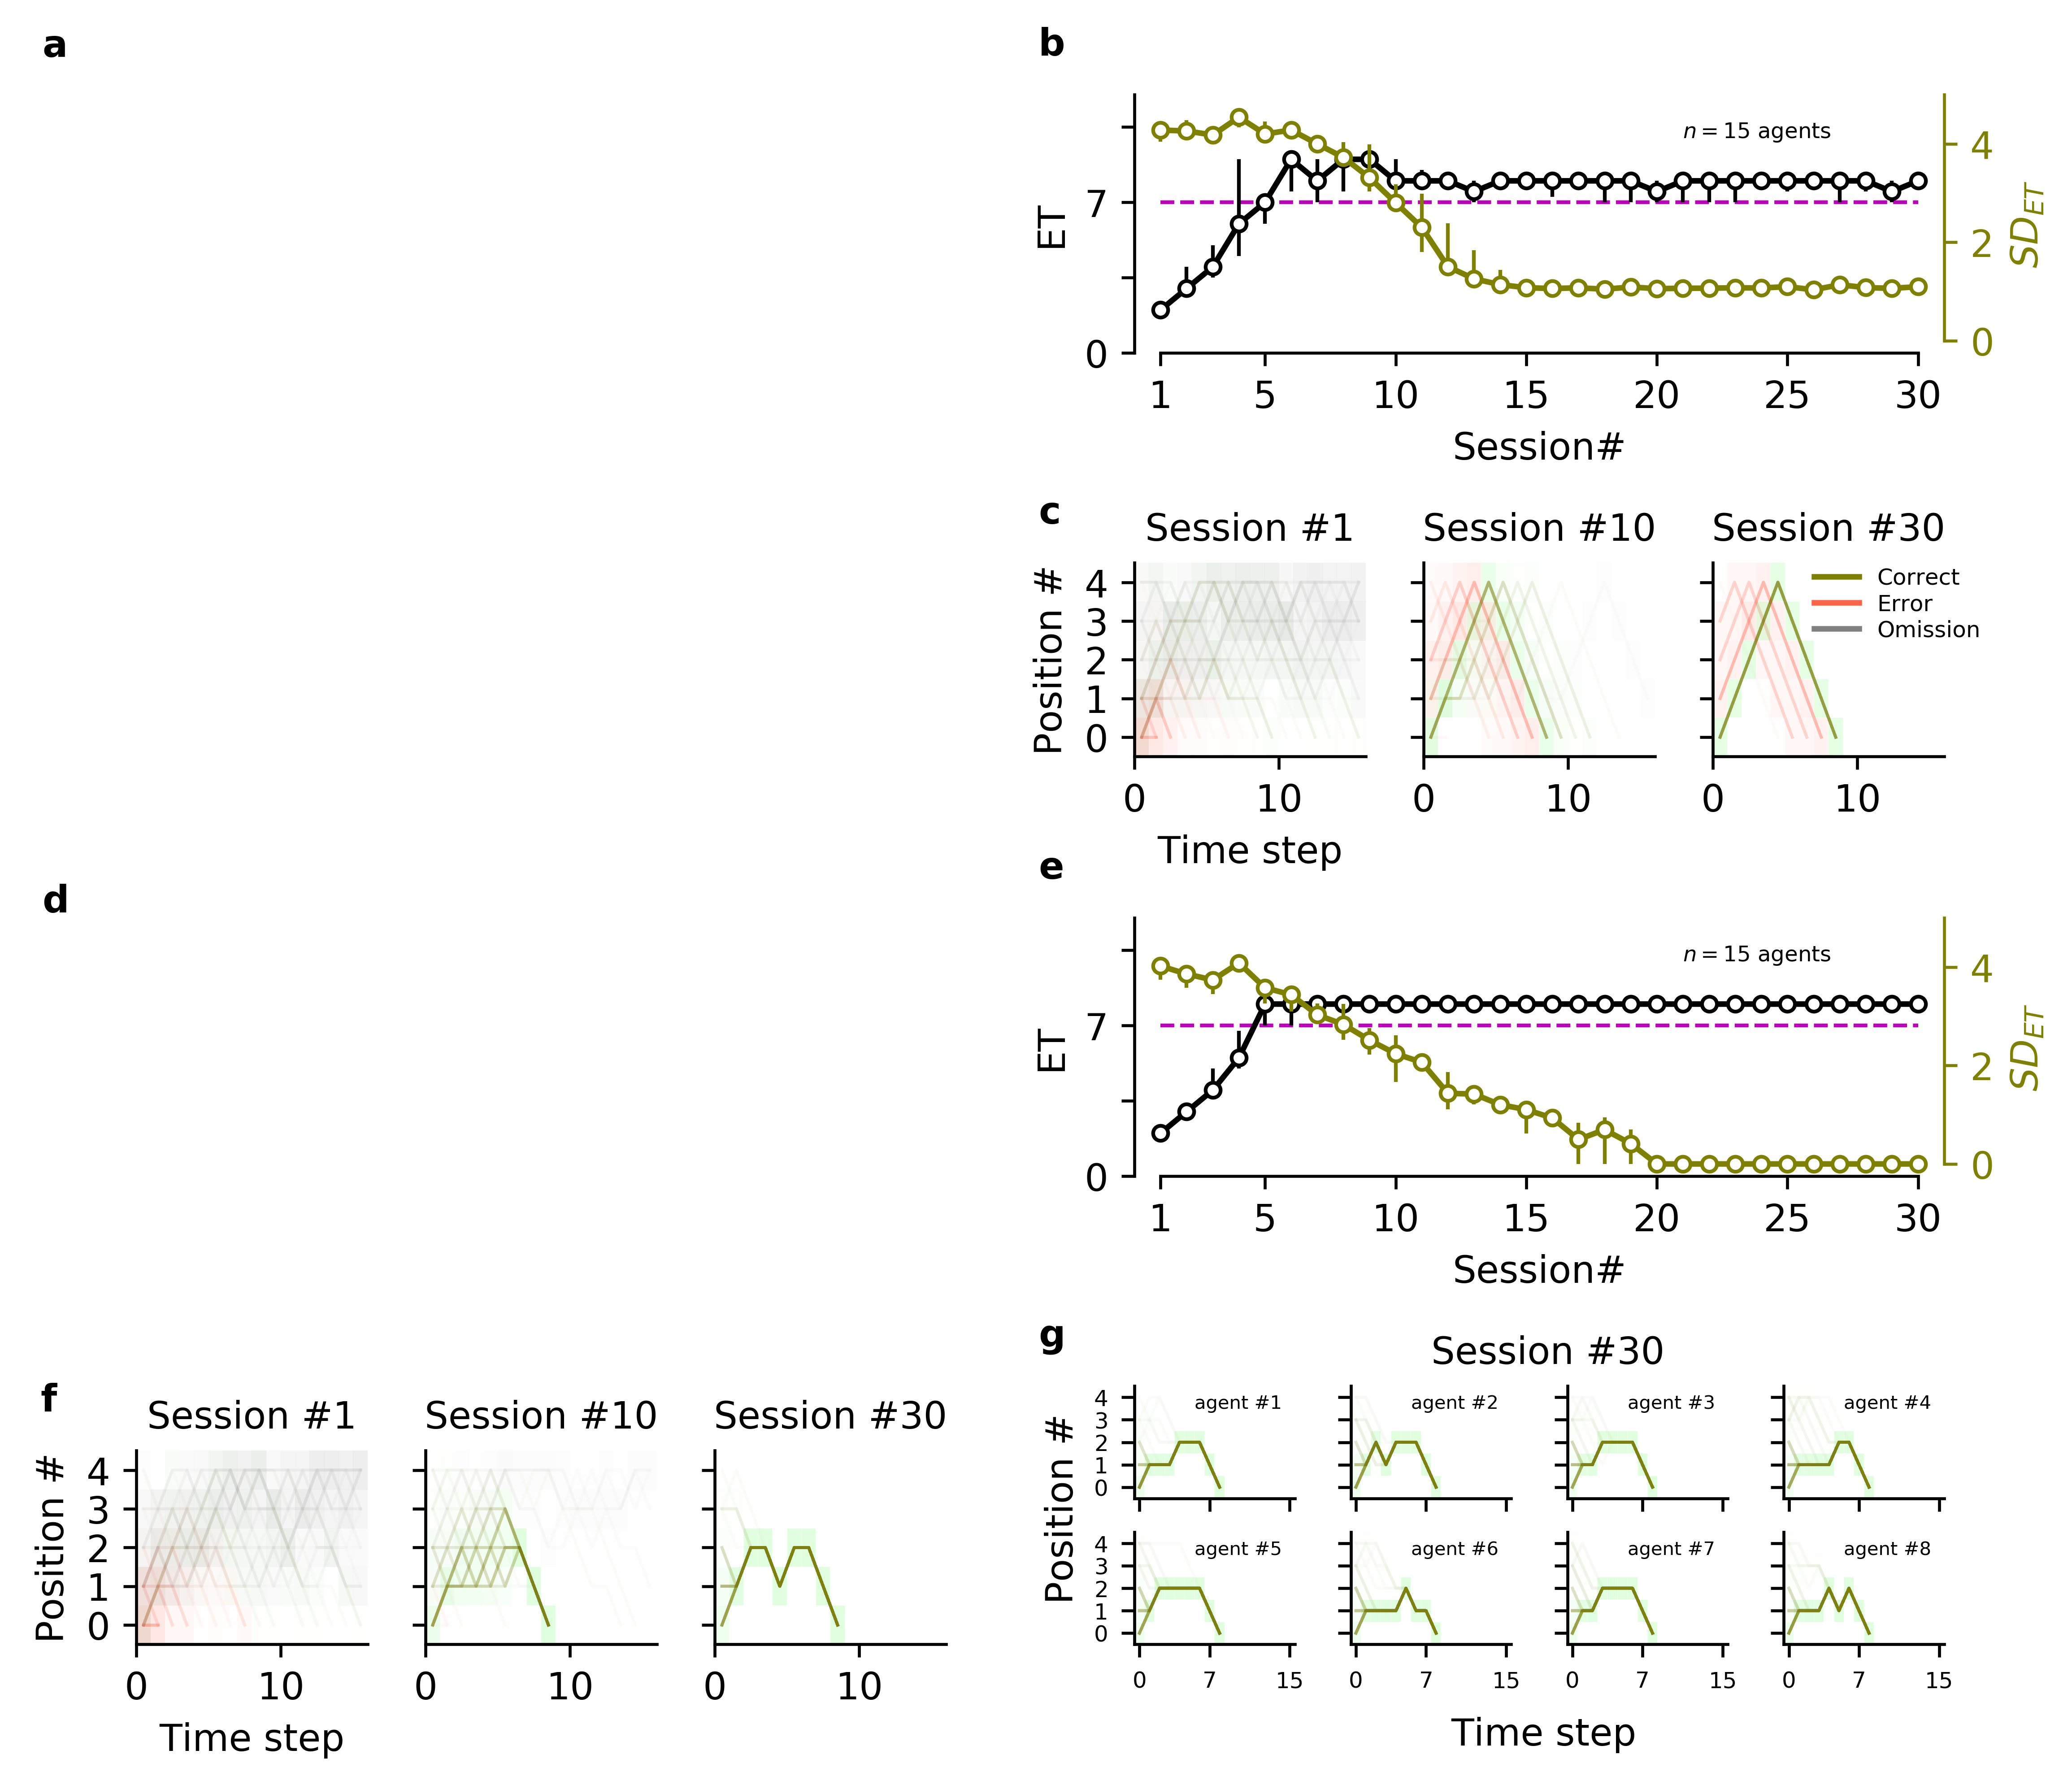

In [5]:
if '__file__' not in dir():

    plt.close('all')
    figsize=(7,6)
    fig=plt.figure(figsize=figsize,dpi=600)

    ################################################################################
    #Panel A: blank space for the schematic of the model position and rear
    gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.02, bottom=0.55, right=0.45, top=.98)
    ax1= fig.add_subplot(gs1[0])
    ax1.axis('off')

    ################################################################################
    #Panel B
    gs3= fig.add_gridspec(nrows=1, ncols=1, left=0.55, bottom=0.82, right=0.98, top=0.98)
    #axes5= plot_trajectory_distributions(fig, gs5,variables)
    ax3=fig.add_subplot(gs3[0])

    TaskParamToPlot = "ET"
    plot_learning_curve(ax3,all_times_median_RP,goalTime,seed_vector,n_sessions,TaskParamToPlot,color='k')
    ax3.set_ylabel(TaskParamToPlot)
    ax3.set_xlabel('Session#')

    TaskParamToPlot = r'$SD_{ET}$'
    colorTwin1 = 'Olive'
    TaskTwinLabel1 = TaskParamToPlot
    ax3_ = ax3.twinx()
    plot_learning_curve(ax3_,all_times_std_RP,goalTime,seed_vector,n_sessions,TaskParamToPlot,color=colorTwin1)
    ax3_.set_ylim([-0.25,5])
    ax3_.set_yticks([0,2,4])
    ax3_.set_yticklabels([0,2,4])
    ax3_.xaxis.set_visible(False)
    ax3_.spines['bottom'].set_visible(False)
    ax3_.spines['top'].set_visible(False)
    ax3_.spines['left'].set_visible(False)
    ax3_.spines['right'].set_visible(True)
    ax3_.spines['right'].set_bounds(0,5)
    ax3_.spines['right'].set_color(colorTwin1)
    ax3_.tick_params(axis='y', colors=colorTwin1)
    ax3_.set_ylabel(TaskTwinLabel1, color=colorTwin1)

    ################################################################################
    #Panel C

    gs2= fig.add_gridspec(nrows=1, ncols=3, left=0.55, bottom=0.57, right=0.98, top=0.69,wspace=0.25,hspace=0.3)
    axes2= plot_trajectory_distributions(fig, gs2,p_TR_correct_RP,p_TR_error_RP,p_TR_omission_RP,sequence_all_states_RP,correct_all_RP,cmapLime,cmapTomato,cmapGray,selected_sessions,alpha=0.5)
    axes2[-1].set_yticklabels([])
    axes2[-1].set_ylabel('')
    for ax in axes2: ax.title.set_fontsize(10)
    add_legend_trajectory(axes2[-1])




    ################################################################################
    #Panel D
    #gs4 = fig.add_gridspec(nrows=1,ncols=1,left=0.02,bottom=0.27,right=0.45,top=0.45)
    gs4 = fig.add_gridspec(nrows=1,ncols=1,left=0.02,bottom=0.22,right=0.45,top=0.45)
    ax4=fig.add_subplot(gs4[0])
    ax4.axis('off')

    ################################################################################
    #Panel E

    selected_agents_TP = [i for i in range(1,9)]

    #gs5= fig.add_gridspec(nrows=1, ncols=3, left=0.02, bottom=0.02, right=0.45, top=0.17,wspace=0.25,hspace=0.3)
    gs5= fig.add_gridspec(nrows=2, ncols=4, left=0.55,bottom=0.02,right=0.98,top=0.18,wspace=0.35,hspace=0.3)
    axes5=plot_final_trajectory_many_agents(fig, gs5,p_TR_correct_last_TP,p_TR_error_last_TP,p_TR_omission_last_TP,sequence_all_states_last_TP,correct_all_last_TP,cmapCorrect,cmapError,cmapOmission,selected_agents_TP,alpha=0.5)
    axes5[-1].set_yticklabels([])
    axes5[-1].set_ylabel('')
    for i_a, ax in enumerate(axes5): 
        ax.title.set_fontsize(10) 
        ax.text(x=6, y=4, s= 'agent #' + str(i_a+1), fontsize=5, zorder=5)       

        if i_a>=4:
            ax.set_xticklabels([str(i) for i in [0,7,15]],fontsize=6)
        else:
            ax.set_xticklabels([])

        if i_a == 0 or i_a == 4:
            ax.set_yticklabels([str(i) for i in range(5)],fontsize=6)
        else:
            ax.set_yticklabels([])


    axes5[1].text(x=8, y=6, s='Session #30', fontsize=10, zorder=5)
    axes5[4].text(x=-9, y=9, s='Position #', fontsize=10, zorder=5, rotation=90)
    axes5[5].text(x=10, y=-4.5, s='Time step', fontsize=10, zorder=5)    
    #add_legend_trajectory(axes5[-1])

    ################################################################################
    #Panel F
    gs6= fig.add_gridspec(nrows=1, ncols=3, left=0.02, bottom=0.02, right=0.45, top=0.14,wspace=0.25,hspace=0.3)
    axes6=plot_trajectory_distributions(fig, gs6,p_TR_correct_TP,p_TR_error_TP,p_TR_omission_TP,sequence_all_states_TP,correct_all_TP,cmapLime,cmapTomato,cmapGray,selected_sessions,alpha=0.5)
    axes6[-1].set_yticklabels([])
    axes6[-1].set_ylabel('')
    #for ax in axes6: ax.title.set_fontsize(10)
    #add_legend_trajectory(axes6[-1])

    ################################################################################
    #Panel G  
    gs7 = fig.add_gridspec(nrows=1,ncols=1,left=0.55, bottom=0.31, right=0.98, top=0.47,wspace=0.25,hspace=0.3)
    ax7=fig.add_subplot(gs7[0])

    TaskParamToPlot = "ET"
    plot_learning_curve(ax7,all_times_median_TP,goalTime,seed_vector,n_sessions,TaskParamToPlot,color='k')
    ax7.set_ylabel(TaskParamToPlot)
    ax7.set_xlabel('Session#')

    TaskParamToPlot = r'$SD_{ET}$'
    colorTwin1 = 'Olive'
    TaskTwinLabel1 = TaskParamToPlot
    ax7_ = ax7.twinx()
    plot_learning_curve(ax7_,all_times_std_TP,goalTime,seed_vector,n_sessions,TaskParamToPlot,color=colorTwin1)
    ax7_.set_ylim([-0.25,5])
    ax7_.set_yticks([0,2,4])
    ax7_.set_yticklabels([0,2,4])
    ax7_.xaxis.set_visible(False)
    ax7_.spines['bottom'].set_visible(False)
    ax7_.spines['top'].set_visible(False)
    ax7_.spines['left'].set_visible(False)
    ax7_.spines['right'].set_visible(True)
    ax7_.spines['right'].set_bounds(0,5)
    ax7_.spines['right'].set_color(colorTwin1)
    ax7_.tick_params(axis='y', colors=colorTwin1)
    ax7_.set_ylabel(TaskTwinLabel1, color=colorTwin1)


    ##########################################################################################################    
    AXES=([ax1,ax3,axes2[0],ax4,ax7,axes6[0],axes5[0]])
    OFFX=(.05,)*len(AXES)
    OFFY=(.03,)*len(AXES)
    add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)     
    ##########################################################################################################

    fig.savefig('FiguresRL/Fig8.pdf',bbox_inches='tight')


## Figure S3 of the paper

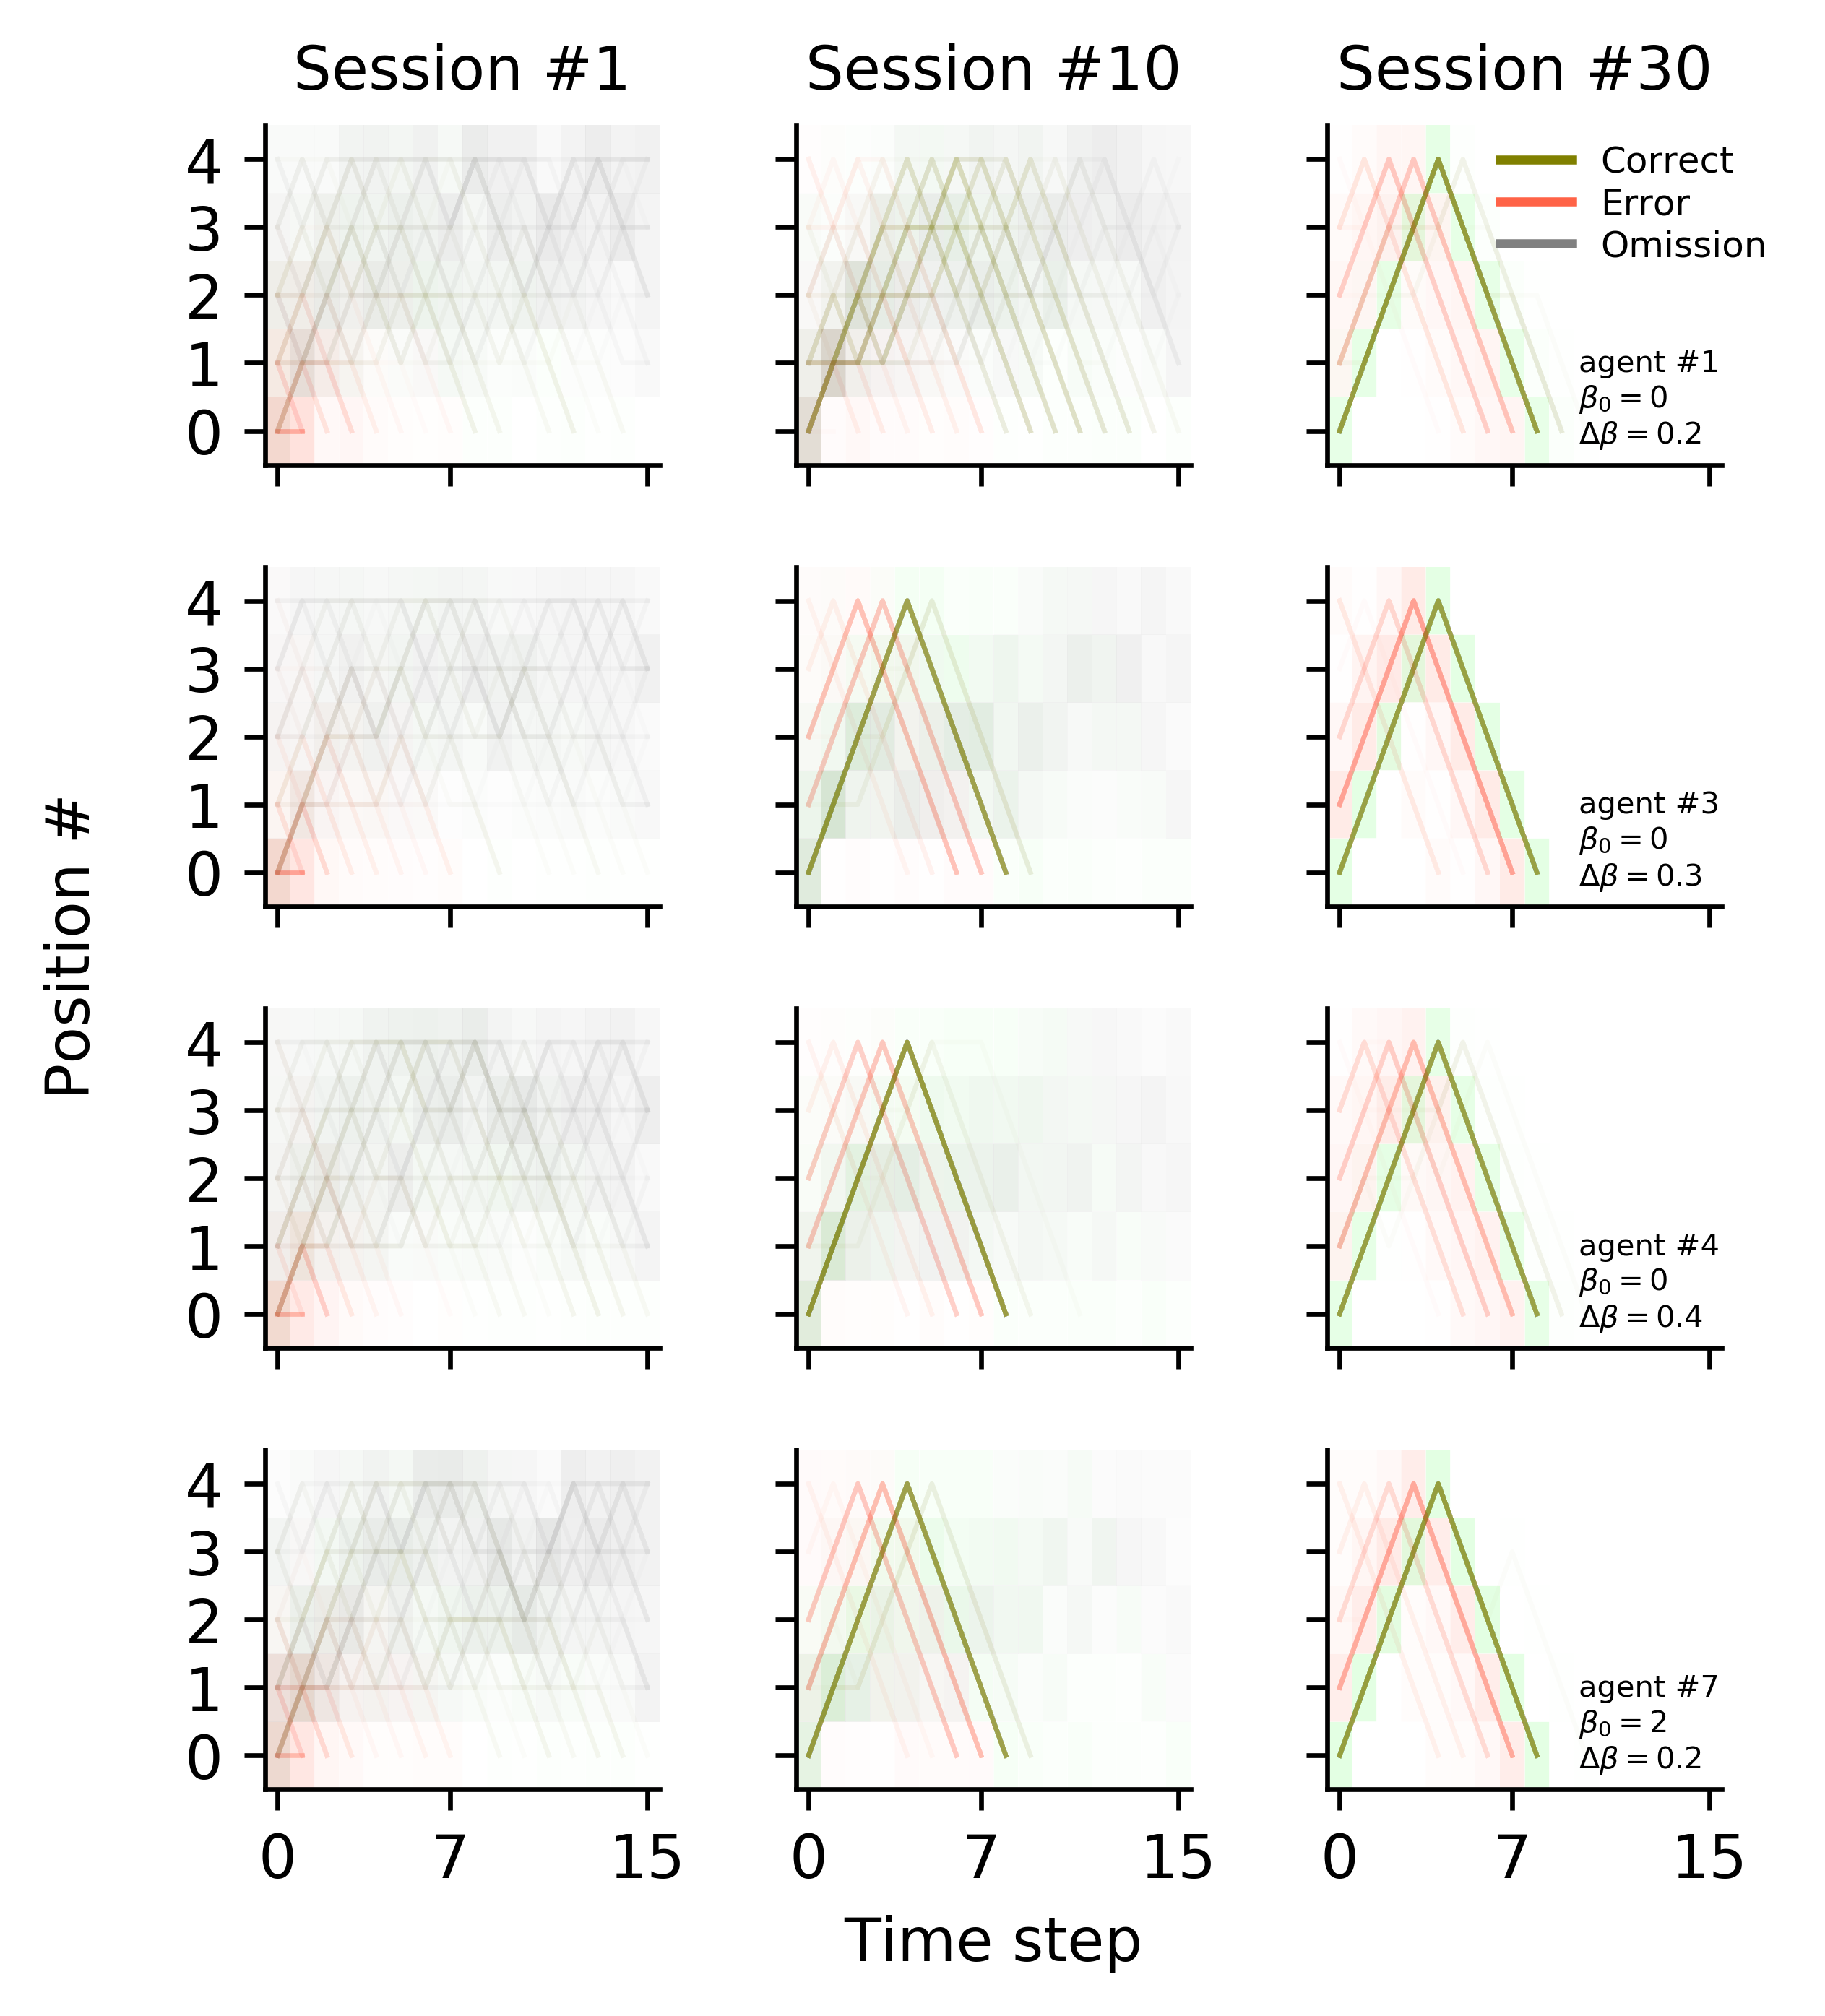

In [6]:
if '__file__' not in dir():

    plt.close('all')
    figsize=(3.5,4)
    fig=plt.figure(figsize=figsize,dpi=600)

    selected_agents_RP = [0,2,3,6]
    selected_sessions_RP = [0,9,29]

    ################################################################################
    #Panel Left: session #1
    gs1= fig.add_gridspec(nrows=4, ncols=1, left=0.02, bottom=0.02, right=0.28, top=.98,hspace=0.3)
    axes1=plot_final_trajectory_many_agents(fig, gs1,p_TR_correct_first_RP,p_TR_error_first_RP,p_TR_omission_first_RP,
                                            sequence_all_states_first_RP,correct_all_first_RP,
                                            cmapCorrect,cmapError,cmapOmission,selected_agents_RP,alpha=0.5)
    for i_a, ax in enumerate(axes1):
        if i_a == 0:
            ax.set_title('Session #' + str(selected_sessions_RP[i_a]+1),fontsize=10)

        if i_a == 3:
            ax.set_xticklabels([str(i) for i in [0,7,15]],fontsize=10)
        else:
            ax.set_xticklabels([])

        ax.set_yticklabels([str(i) for i in range(5)],fontsize=10)



    ################################################################################
    #Panel Center: session #10
    gs2= fig.add_gridspec(nrows=4, ncols=1, left=0.37, bottom=0.02, right=0.63, top=.98,hspace=0.3)
    axes2=plot_final_trajectory_many_agents(fig, gs2,p_TR_correct_intermediate_RP,p_TR_error_intermediate_RP,p_TR_omission_intermediate_RP,
                                            sequence_all_states_intermediate_RP,correct_all_intermediate_RP,
                                            cmapCorrect,cmapError,cmapOmission,selected_agents_RP,alpha=0.5)

    for i_a, ax in enumerate(axes2):
        if i_a == 0:
            ax.set_title('Session #' + str(selected_sessions_RP[i_a+1]+1),fontsize=10)

        if i_a == 3:
            ax.set_xticklabels([str(i) for i in [0,7,15]],fontsize=10)
        else:
            ax.set_xticklabels([])

        ax.set_yticklabels([])

    ################################################################################
    #Panel Right: session #30
    gs3= fig.add_gridspec(nrows=4, ncols=1, left=0.72, bottom=0.02, right=0.98, top=.98,hspace=0.3)
    axes3=plot_final_trajectory_many_agents(fig, gs3,p_TR_correct_last_RP,p_TR_error_last_RP,p_TR_omission_last_RP,
                                            sequence_all_states_last_RP,correct_all_last_RP,
                                            cmapCorrect,cmapError,cmapOmission,selected_agents_RP,alpha=0.5)

    add_legend_trajectory(axes3[0])
    for i_a, ax in enumerate(axes3):
        if i_a == 0:
            ax.set_title('Session #' + str(selected_sessions_RP[i_a+2]+1),fontsize=10)
        ax.text(x=10.2, y=0.3, s= 'agent #' + str(selected_agents_RP[i_a]+1) + '\n' + r'$\beta_0=$' + str(int(invT_vect[i_a])) 
                + '\n' + r'$\Delta\beta=$' + str(invT_step_vect[i_a]),fontsize=5, zorder=5)       
       # ax.text(x=10, y=1, s= 'agent #' + str(selected_agents_RP[i_a]+1),fontsize=5, zorder=5)       

        if i_a == 3:
            ax.set_xticklabels([str(i) for i in [0,7,15]],fontsize=10)
        else:
            ax.set_xticklabels([])

        ax.set_yticklabels([])
    axes2[3].set_xlabel('Time step')    
    axes1[2].text(x=-9, y=7.5, s='Position #', fontsize=10, zorder=5, rotation=90)

    fig.savefig('FiguresRL/FigS3.pdf',bbox_inches='tight')
